In [1]:
import os
from torch.utils.data import Dataset, DataLoader, ConcatDataset,  WeightedRandomSampler
from skimage import io, transform
from torchvision import transforms, utils
import torch
import numpy as np
import nibabel as nib
from random import randint
from PIL import Image
import torch.optim as optim
import time
import torch.nn as nn
from my_Dataset import TrainDataset
import matplotlib.pyplot as plt
from weight_axial import weight,count
from QN import QuickNat

In [2]:
gpu_id = 0
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)

device = torch.device('cuda')
print(device)

cuda


In [3]:
sub_idx = 0
slice_idx = 1
T1a_dir = '/home/xiaoyu/MRIdata_group/T1w/axial/sub{}/slice{}'.format(sub_idx,slice_idx)
parc1a_dir = '/home/xiaoyu/MRIdata_group/parc_1/axial/sub{}/slice{}'.format(sub_idx,slice_idx)
total_data = TrainDataset(T1a_dir=T1a_dir, parc1a_dir = parc1a_dir)

In [4]:
for sub_idx in range(1):
    T1a_dir = '/home/xiaoyu/MRIdata_group/T1w/axial/sub{}/slice{}'.format(sub_idx,slice_idx)
    parc1a_dir = '/home/xiaoyu/MRIdata_group/parc_1/axial/sub{}/slice{}'.format(sub_idx,slice_idx)
    train_data = TrainDataset(T1a_dir=T1a_dir, parc1a_dir = parc1a_dir)
    total_data = total_data + train_data
print(len(total_data))

20


In [5]:
dataloader = DataLoader(total_data, batch_size = 1, shuffle = True, num_workers = 4)
print(len(dataloader))

20


In [6]:
params= {'num_channels':1, 'num_filters':64, 'kernel_h':5, 'kernel_w':5, 'kernel_c':1, 'stride_conv':1,'pool':2, 
         'stride_pool':2, 'num_class':178, 'se_block': 'CSSE','drop_out':0.2}
model = QuickNat(params)
start=time.time()
nb_param=0
for param in model.parameters():
    nb_param+=np.prod(list(param.data.size()))
print(nb_param)

3526721


In [7]:
print(model)

QuickNat(
  (encode1): EncoderBlock(
    (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv2): Conv2d(65, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv3): Conv2d(129, 64, kernel_size=(1, 1), stride=(1, 1))
    (batchnorm1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batchnorm2): BatchNorm2d(65, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batchnorm3): BatchNorm2d(129, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=1)
    (drop_out): Dropout2d(p=0.2)
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encode2): EncoderBlock(
    (conv1): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv2): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv3): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
    (batchnorm1): BatchNorm2d(64, 

In [8]:
bs=5
x=torch.rand(bs,1,128,128)
y = model(x)
print(y.size())

torch.Size([5, 178, 128, 128])


In [9]:
model = model.to(device)
weight = weight.to(device)
criterion = nn.NLLLoss(weight = weight)
optimizer = optim.Adam(model.parameters() ,lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.85)

In [10]:
loss_list = []
for epoch in range(0,2000):
    running_loss = 0
    num_batches = 0
    scheduler.step()
    for i_batch, sample_batched in enumerate(dataloader):
    
        optimizer.zero_grad()
        
        #get the inputs
        inputs, labels = sample_batched['T1a'], sample_batched['parc1a']
        

        inputs = inputs.to(device)
        labels = labels.to(device)

        inputs.requires_grad_()
        
        #forward + backward +optimize
        scores = model(inputs)

          
        # Define the loss
        loss = criterion(scores, labels.long()) 
        loss.backward()
        optimizer.step()
        
        # compute and accumulate stats
        running_loss += loss.detach().item()

       
        num_batches+=1 
        
        
    # AVERAGE STATS THEN DISPLAY    
    total_loss = running_loss/num_batches
    loss_list = np.append(loss_list,total_loss)
   
    elapsed = (time.time()-start)/60
        
    print('epoch=',epoch, '\t time=', elapsed,'min', '\t loss=', total_loss ) 
    if epoch%50==0:
        print(loss_list)
        torch.save(model.state_dict(),'model')
   
 
print('Finish Training')

epoch= 0 	 time= 0.13354098399480183 min 	 loss= 4.925171542167663
[4.92517154]
epoch= 1 	 time= 0.1681247353553772 min 	 loss= 4.117779421806335
epoch= 2 	 time= 0.20226085980733235 min 	 loss= 3.4000993430614472
epoch= 3 	 time= 0.2369896451632182 min 	 loss= 3.031698301434517
epoch= 4 	 time= 0.27477798859278363 min 	 loss= 2.863983911275864
epoch= 5 	 time= 0.3090762694676717 min 	 loss= 2.6729476511478425
epoch= 6 	 time= 0.3451522350311279 min 	 loss= 2.417430019378662
epoch= 7 	 time= 0.3834357976913452 min 	 loss= 2.1779849350452425
epoch= 8 	 time= 0.42239676316579183 min 	 loss= 1.992388278245926
epoch= 9 	 time= 0.46043285926183064 min 	 loss= 1.8316055953502655
epoch= 10 	 time= 0.4945728023846944 min 	 loss= 1.7364402890205384
epoch= 11 	 time= 0.5298711697260539 min 	 loss= 1.6997969210147859
epoch= 12 	 time= 0.5658544818560283 min 	 loss= 1.6368350967764855
epoch= 13 	 time= 0.5993229945500692 min 	 loss= 1.5225629225373267
epoch= 14 	 time= 0.6345714966456095 min 	 los

KeyboardInterrupt: 

In [ ]:
# plt.plot(loss_list)

In [ ]:
# l = loss_list[0]
# sum_dif = []
# for loss in loss_list:
#     dif = l-loss
#     l = loss
# #     num = np.random.randint(1, 20)
# #     print(num)

# #     if(num == 7):
# #         break
#     sum_dif = np.append(sum_dif,dif)
# print(sum_dif)
# plt.plot(sum_dif)

In [11]:
def show_mask(image, mask):
    """
    Show image and mask
    Args:
        image(numpyarray): The training image
        semantic(numpyarray): The training image segmentation
    """    
    plt.subplot(1,2,1)
    plt.title('image')
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.title('mask')
    plt.imshow(mask)
    plt.show()

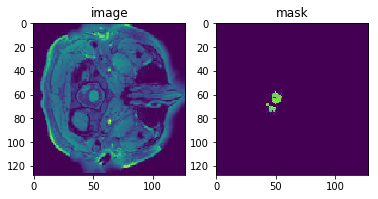

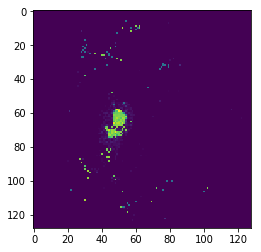

In [12]:
sample=total_data[4]
img = sample['T1a']
mask = sample['parc1a']

show_mask(img.squeeze(), mask)

img = img.unsqueeze(dim = 0)

img = img.to(device)


# feed it to network
scores =  model(img)
scores = scores.detach().cpu().squeeze().permute(1,2,0)

scores = torch.exp(scores)

a,b = torch.max(scores,dim=2)
plt.imshow(b)
